In [1]:
import ast
import os
import re
import time
from glob import glob
from typing import Literal, Union

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from scipy.ndimage import binary_dilation, label
from scipy.spatial import cKDTree
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm

# Functions

In [2]:
def read_h5(file_path):
    """
    Reads cutout data from HDF5 file
    :param file_path: path to HDF5 file
    :return: cutout data
    """
    with h5py.File(file_path, "r") as f:
        # Create empty dictionaries to store data for each group
        cutout_data = {}

        # Loop through datasets
        for dataset_name in f:
            if dataset_name == "images":
                data = np.nan_to_num(np.array(f[dataset_name]), nan=0.0)
            else:
                data = np.array(f[dataset_name])
            cutout_data[dataset_name] = data
    return cutout_data


def extract_and_save_objects(
    catalog_path, output_dir, base_path="/projects/unions/ssl/data/raw/tiles/dwarforge"
):
    """
    Extract objects from HDF5 files based on a catalog and save them to new HDF5 files in chunks of 5000 objects.

    Parameters:
    -----------
    catalog_path : str
        Path to the catalog file containing 'tile', 'unique_id', 'Z', and 'LOGM_CIGALE' columns.
    output_dir : str
        Directory where output HDF5 files will be saved.
    base_path : str
        Base path to the directory containing the tile directories.

    Returns:
    --------
    tuple
        (objects_processed, objects_not_found, files_created)
    """
    # 1. Load and prepare the catalog
    print("Loading catalog...")
    catalog = pd.read_csv(catalog_path, low_memory=False)

    # Check if required columns exist
    required_cols = ["tile", "unique_id", "Z", "LOGM_CIGALE"]
    for col in required_cols:
        if col not in catalog.columns:
            raise ValueError(f"Required column '{col}' not found in catalog")

    # 2. Group objects by tile
    print("Grouping objects by tile...")
    grouped_catalog = catalog.groupby("tile")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize data accumulation
    accumulated_data = {}
    accumulated_count = 0
    datasets_to_extract = None
    bands_data = None
    tile_data = None

    # Counters for statistics
    total_objects = len(catalog)
    objects_processed = 0
    objects_not_found = 0
    files_created = 0

    print(
        f"Processing {len(grouped_catalog)} unique tiles with {total_objects} total objects..."
    )

    # 3. Process each tile
    for tile, tile_objects in tqdm(grouped_catalog):
        # Get the tile format
        tile_formatted = str(tile)
        # Construct file path
        tile_path = f"{base_path}/{tile_formatted}/gri/{tile_formatted}_matched_cutouts_full_res_final.h5"

        try:
            with h5py.File(tile_path, "r") as src_file:
                # 4. Create object index mapping
                unique_ids = src_file["unique_id"][:]
                id_to_index = {uid: idx for idx, uid in enumerate(unique_ids)}

                # Store bands data (only need to do this once)
                if bands_data is None:
                    bands_data = src_file["band_names"][:]
                    tile_data = src_file["tile"][:]

                # Get list of datasets to copy (all except 'bands')
                if datasets_to_extract is None:
                    datasets_to_extract = [
                        key
                        for key in src_file.keys()
                        if key not in ["band_names", "tile"]
                    ]

                    # Initialize data accumulation
                    for dataset_name in datasets_to_extract:
                        accumulated_data[dataset_name] = []

                    # Add our new datasets
                    accumulated_data["Z"] = []
                    accumulated_data["LOGM_CIGALE"] = []

                # 5. Select objects for extraction
                tile_objects_array = tile_objects["unique_id"].values
                valid_indices = []
                valid_catalog_indices = []

                for cat_idx, uid in enumerate(tile_objects_array):
                    if uid in id_to_index:
                        valid_indices.append(id_to_index[uid])
                        valid_catalog_indices.append(cat_idx)
                    else:
                        objects_not_found += 1

                n_valid = len(valid_indices)
                if n_valid == 0:
                    print(f"No valid objects found in tile {tile_formatted}")
                    continue

                # 6. Extract data for each dataset
                for dataset_name in datasets_to_extract:
                    extracted_data = src_file[dataset_name][:][valid_indices]
                    accumulated_data[dataset_name].append(extracted_data)

                # Add Z and LOGM_CIGALE from catalog
                z_values = tile_objects.iloc[valid_catalog_indices]["Z"].values
                logm_values = tile_objects.iloc[valid_catalog_indices][
                    "LOGM_CIGALE"
                ].values

                accumulated_data["Z"].append(z_values)
                accumulated_data["LOGM_CIGALE"].append(logm_values)

                # Update object counts
                accumulated_count += n_valid
                objects_processed += n_valid

                # Check if we have enough objects to save a chunk
                while accumulated_count >= 5000:
                    # Save a chunk of exactly 5000 objects
                    accumulated_count = save_chunk(
                        accumulated_data,
                        bands_data,
                        tile_data,
                        output_dir,
                        files_created,
                        accumulated_count,
                    )
                    files_created += 1

        except FileNotFoundError:
            print(f"Warning: File not found for tile {tile_formatted} at {tile_path}")
            objects_not_found += len(tile_objects)

    # Save any remaining objects
    if accumulated_count > 0:
        save_chunk(
            accumulated_data,
            bands_data,
            tile_data,
            output_dir,
            files_created,
            accumulated_count,
            is_final=True,
        )
        files_created += 1

    print(f"Processing complete:")
    print(f"  Total objects processed: {objects_processed}/{total_objects}")
    print(f"  Objects not found: {objects_not_found}")
    print(f"  Output files created: {files_created}")

    return objects_processed, objects_not_found, files_created


def save_chunk(
    accumulated_data,
    bands_data,
    tile_data,
    output_dir,
    chunk_index,
    accumulated_count,
    is_final=False,
):
    """
    Save a chunk of exactly 5000 objects (or fewer if it's the last chunk) to an HDF5 file.

    Parameters:
    -----------
    accumulated_data : dict
        Dictionary containing lists of arrays for each dataset
    bands_data : ndarray
        The 'bands' dataset to save with each chunk
    tile_data : ndarray
        The 'tile' dataset to save with each chunk
    output_dir : str
        Directory to save the output file
    chunk_index : int
        Index for the chunk file name
    accumulated_count : int
        Total number of objects accumulated
    is_final : bool, optional
        Whether this is the final chunk (may be less than 5000 objects)

    Returns:
    --------
    int
        Number of objects remaining after saving the chunk
    """
    output_path = os.path.join(output_dir, f"chunk_{chunk_index:04d}.h5")

    # Determine how many objects to save
    objects_to_save = 5000 if not is_final else accumulated_count
    objects_to_save = min(objects_to_save, accumulated_count)

    print(f"Saving chunk {chunk_index} with {objects_to_save} objects to {output_path}")

    # Create a dictionary to store concatenated data
    concatenated_data = {}

    # Concatenate arrays for each dataset
    for dataset_name, arrays in accumulated_data.items():
        if arrays:  # Check if there are any arrays to concatenate
            concatenated_data[dataset_name] = np.concatenate(arrays)

    # Open output file and save data
    with h5py.File(output_path, "w") as out_file:
        # Save each dataset (first objects_to_save objects)
        for dataset_name, data in concatenated_data.items():
            chunk_data = data[:objects_to_save]
            out_file.create_dataset(dataset_name, data=chunk_data)

        # Save the bands dataset
        out_file.create_dataset("band_names", data=bands_data)
        out_file.create_dataset("tile", data=tile_data)

    # Update the accumulated_data to keep remaining objects
    for dataset_name, data in concatenated_data.items():
        if len(data) > objects_to_save:
            accumulated_data[dataset_name] = [data[objects_to_save:]]
        else:
            accumulated_data[dataset_name] = []

    # Return the number of objects remaining
    return accumulated_count - objects_to_save

# RGB Functions

In [340]:
def preprocess_cutout(
    cutout: np.ndarray, mode: str = "vis", replace_anomaly: bool = True
) -> np.ndarray:
    """Create an RGB image from the cutout data and save or plot it.

    Args:
        cutout (numpy.ndarray): cutout data with shape (channels, height, width)
        mode (str, optional): mode of operation. Defaults to 'training'. Valid options are 'training' or 'vis'. Fills missing channels for visualization.

    Returns:
        numpy.ndarray: preprocessed image cutout

    """
    # map out bands to RGB
    cutout_red = cutout[2]  # i-band
    cutout_green = cutout[1]  # r-band
    cutout_blue = cutout[0]  # g-band

    # adjust zero-point for the g-band
    if np.count_nonzero(cutout_blue) > 0:
        cutout_blue = adjust_flux_with_zp(cutout_blue, 27.0, 30.0)

    if replace_anomaly:
        # replace anomalies
        cutout_red = detect_anomaly(cutout_red)
        cutout_green = detect_anomaly(cutout_green)
        cutout_blue = detect_anomaly(cutout_blue)

    # synthesize missing channel from the existing ones
    # longest valid wavelength is mapped to red, middle to green, shortest to blue
    if mode == "vis":
        if np.count_nonzero(cutout_red > 1e-10) == 0:
            cutout_red = cutout_green
            cutout_green = (cutout_green + cutout_blue) / 2
        elif np.count_nonzero(cutout_green > 1e-10) == 0:
            cutout_green = (cutout_red + cutout_blue) / 2
        elif np.count_nonzero(cutout_blue > 1e-10) == 0:
            cutout_blue = cutout_red
            cutout_red = (cutout_red + cutout_green) / 2

    # stack the channels in the order red, green, blue
    cutout_prep = np.stack([cutout_red, cutout_green, cutout_blue], axis=-1)

    return cutout_prep


def generate_rgb(
    cutout: np.ndarray,
    scaling_type: Literal["asinh", "linear"] = "asinh",
    stretch: float = 125,
    Q: float = 7.0,
    gamma: float = 0.25,
) -> np.ndarray:
    """Create an RGB image from three bands of data preserving relative intensities.

    Processes multi-band astronomical data into a properly scaled RGB image
    suitable for visualization, handling high dynamic range and empty channels.

    Args:
        cutout: 3D array of shape (height, width, 3) with band data
        scaling_type: Type of scaling to apply ("asinh" or "linear")
        stretch: Scaling factor controlling overall brightness
        Q: Softening parameter for asinh scaling (higher = more linear)
        gamma: Gamma correction factor (lower = enhances faint features)

    Returns:
        Normalized RGB image with values in range [0, 1]

    Notes:
        For astronomical data with high dynamic range, "asinh" scaling is
        typically preferred as it preserves both bright and faint details.
    """
    frac = 0.1
    with np.errstate(divide="ignore", invalid="ignore"):
        red = cutout[:, :, 0]
        green = cutout[:, :, 1]
        blue = cutout[:, :, 2]

        # Check for zero channels
        red_is_zero = np.all(red == 0)
        green_is_zero = np.all(green == 0)
        blue_is_zero = np.all(blue == 0)

        # Compute average intensity before scaling choice (avoiding zero channels)
        nonzero_channels = []
        if not red_is_zero:
            nonzero_channels.append(red)
        if not green_is_zero:
            nonzero_channels.append(green)
        if not blue_is_zero:
            nonzero_channels.append(blue)

        if nonzero_channels:
            i_mean = sum(nonzero_channels) / len(nonzero_channels)
        else:
            i_mean = np.zeros_like(red)  # All channels are zero

        if scaling_type == "asinh":
            # Apply asinh scaling
            if not red_is_zero:
                red = red * np.arcsinh(Q * i_mean / stretch) / (Q * i_mean)
            if not green_is_zero:
                green = green * np.arcsinh(Q * i_mean / stretch) / (Q * i_mean)
            if not blue_is_zero:
                blue = blue * np.arcsinh(Q * i_mean / stretch) / (Q * i_mean)
        elif scaling_type == "asinh_frac":
            # Apply asinh scaling
            if not red_is_zero:
                red = (
                    red
                    * np.arcsinh(Q * i_mean / stretch)
                    * frac
                    / (np.arcsinh(frac * Q) * i_mean)
                )
            if not green_is_zero:
                green = (
                    green
                    * np.arcsinh(Q * i_mean / stretch)
                    * frac
                    / (np.arcsinh(frac * Q) * i_mean)
                )
            if not blue_is_zero:
                blue = (
                    blue
                    * np.arcsinh(Q * i_mean / stretch)
                    * frac
                    / (np.arcsinh(frac * Q) * i_mean)
                )
        elif scaling_type == "linear":
            # Apply linear scaling
            if not red_is_zero:
                red = red * stretch
            if not green_is_zero:
                green = green * stretch
            if not blue_is_zero:
                blue = blue * stretch
        else:
            raise ValueError(f"Unknown scaling type: {scaling_type}")

        # Apply gamma correction while preserving sign
        if gamma is not None:
            if not red_is_zero:
                red_mask = abs(red) <= 1e-9
                red = np.sign(red) * (abs(red) ** gamma)
                red[red_mask] = 0

            if not green_is_zero:
                green_mask = abs(green) <= 1e-9
                green = np.sign(green) * (abs(green) ** gamma)
                green[green_mask] = 0

            if not blue_is_zero:
                blue_mask = abs(blue) <= 1e-9
                blue = np.sign(blue) * (abs(blue) ** gamma)
                blue[blue_mask] = 0
        # Stack the channels after scaling and gamma correction
        result = np.stack([red, green, blue], axis=-1).astype(np.float32)

    # back to original axis ordering
    result = np.moveaxis(result, -1, 0)

    return result


def adjust_flux_with_zp(
    flux: np.ndarray, current_zp: Union[float, int], standard_zp: Union[float, int]
) -> np.ndarray:
    """
    Adjust flux values to a standard zero-point.

    Args:
        flux (numpy.ndarray): Flux values to adjust.
        current_zp (float/int): Current zero-point of the flux values.
        standard_zp (float/int): Standard zero-point to adjust to.

    Returns:
        numpy.ndarray: Adjusted flux values.
    """
    adjusted_flux = flux * 10 ** (-0.4 * (current_zp - standard_zp))
    return adjusted_flux


def detect_anomaly(
    image: np.ndarray,
    zero_threshold: float = 0.05,
    min_size: int = 50,
    replace_anomaly: bool = True,
    dilate_mask: bool = True,
    dilation_iters: int = 1,
) -> np.ndarray:
    """
    Detect and replace anomalies in an image using wavelet decomposition.

    This function analyzes an astronomical image to identify anomalous regions
    by performing wavelet decomposition and identifying regions with minimal
    fluctuations below a threshold. It can optionally replace detected anomalous
    pixels with zeros.

    Args:
        image: Input astronomical image to process
        zero_threshold: Fluctuation threshold below which an anomaly is detected
        min_size: Minimum connected pixel count to be considered an anomaly
        replace_anomaly: Whether to set anomalous pixels to zero
        dilate_mask: Whether to expand the detected anomaly mask
        dilation_iters: Number of dilation iterations if dilate_mask is True

    Returns:
        Processed image with anomalies optionally replaced

    Notes:
        This function uses Haar wavelet decomposition to identify regions with
        suspiciously low variation, which often indicate detector artifacts or
        other non-astronomical features in the image.
    """
    # replace nan values with zeros
    image[np.isnan(image)] = 0.0

    # Perform a 2D Discrete Wavelet Transform using Haar wavelets
    coeffs = pywt.dwt2(image, "haar")
    cA, (cH, cV, cD) = coeffs  # Decomposition into approximation and details

    # Create binary masks where wavelet coefficients are below the threshold
    mask_horizontal = np.abs(cH) <= zero_threshold
    mask_vertical = np.abs(cV) <= zero_threshold
    mask_diagonal = np.abs(cD) <= zero_threshold

    masks = [mask_diagonal, mask_horizontal, mask_vertical]

    # Create a global mask to accumulate all anomalies
    global_mask = np.zeros_like(image, dtype=bool)
    # Create masks for each component
    component_masks = np.zeros((3, cA.shape[0], cA.shape[1]), dtype=bool)
    anomalies = np.zeros(3, dtype=bool)
    for i, mask in enumerate(masks):
        # Apply connected-component labeling to find connected regions in the mask
        labeled_array, num_features = label(mask)  # type: ignore

        # Calculate the sizes of all components
        component_sizes = np.bincount(labeled_array.ravel())

        # Check if any component is larger than the minimum size
        anomaly_detected = np.any(component_sizes[1:] >= min_size)
        anomalies[i] = anomaly_detected

        if not anomaly_detected:
            continue

        # Prepare to accumulate a total mask
        total_feature_mask = np.zeros_like(image, dtype=bool)

        # Loop through all labels to find significant components
        for component_label in range(
            1, num_features + 1
        ):  # Start from 1 to skip background
            if component_sizes[component_label] >= min_size:
                # Create a binary mask for this component
                component_mask = labeled_array == component_label
                # add component mask to component masks
                component_masks[i] |= component_mask
                # Upscale the mask to match the original image dimensions
                upscaled_mask = np.kron(component_mask, np.ones((2, 2), dtype=bool))
                # Accumulate the upscaled feature mask
                total_feature_mask |= upscaled_mask

        # Accumulate global mask
        global_mask |= total_feature_mask
        # Dilate the masks to catch some odd pixels on the outskirts of the anomaly
        if dilate_mask:
            global_mask = binary_dilation(global_mask, iterations=dilation_iters)
            for j, comp_mask in enumerate(component_masks):
                component_masks[j] = binary_dilation(
                    comp_mask, iterations=dilation_iters
                )
    # Replace the anomaly with zeros
    if replace_anomaly:
        image[global_mask] = 0.0

    return image


def preprocess_h5_images(
    h5_file_path,
    output_dir=None,
    replace_anomaly=True,
    scaling_type="asinh",
    mode='vis',
    stretch=125,
    Q=7.0,
    gamma=0.25,
    use_compression=False,
):
    """
    Read an H5 file containing image cutouts, preprocess them, and save to a new H5 file.

    Parameters:
    -----------
    h5_file_path : str
        Path to the input H5 file containing image cutouts.
    output_dir : str, optional
        Directory where the processed H5 file will be saved. If None, uses same directory as input.
    replace_anomaly : bool, optional
        Whether to replace anomalies in the images. Default is True.
    scaling_type : str, optional
        Type of scaling to apply ("asinh" or "linear"). Default is "asinh".
    stretch : float, optional
        Scaling factor controlling overall brightness. Default is 125.
    Q : float, optional
        Softening parameter for asinh scaling. Default is 7.0.
    gamma : float, optional
        Gamma correction factor. Default is 0.25.
    use_compression : bool, optional
        Whether to compress the output datasets. Default is False for faster read
        times during deep learning training.

    Returns:
    --------
    str
        Path to the output H5 file.
    """
    # Set output directory and filename
    if output_dir is None:
        output_dir = os.path.dirname(h5_file_path)

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Generate output filename
    base_name = os.path.basename(h5_file_path)
    output_filename = os.path.splitext(base_name)[0] + "_prep.h5"
    output_path = os.path.join(output_dir, output_filename)

    print(f"Processing {h5_file_path} -> {output_path}")

    # Open input file for reading
    with h5py.File(h5_file_path, "r") as src_file:
        # Get image data
        images = src_file["images"][:]
        num_objects = images.shape[0]

        print(f"Found {num_objects} objects with image shape {images.shape[1:]}")

        # Create output file
        with h5py.File(output_path, "w") as out_file:
            # Process images
            processed_images = np.zeros(
                (num_objects, 3, images.shape[2], images.shape[3]), dtype=np.float32
            )

            print("Processing images...")
            for i in tqdm(range(num_objects)):
                # Get the current cutout (with shape [channels, height, width])
                cutout = images[i]

                # Apply preprocessing to convert to RGB format
                preprocessed = preprocess_cutout(
                    cutout, mode=mode, replace_anomaly=replace_anomaly
                )

                # Apply RGB scaling and normalization
                rgb_image = generate_rgb(
                    preprocessed,
                    scaling_type=scaling_type,
                    stretch=stretch,
                    Q=Q,
                    gamma=gamma,
                )

                # Store processed image
                processed_images[i] = rgb_image

            # Save processed images to output file
            if use_compression:
                out_file.create_dataset(
                    "images",
                    data=processed_images,
                    compression="gzip",
                    compression_opts=6,
                )
            else:
                # No compression for faster read times during training
                out_file.create_dataset("images", data=processed_images)

            # Copy all other datasets from source file
            print("Copying metadata and other datasets...")
            for key in src_file.keys():
                if key != "images" and key not in out_file:
                    src_file.copy(key, out_file)

            # Add processing parameters as attributes
            out_file.attrs["preprocessing_replace_anomaly"] = replace_anomaly
            out_file.attrs["rgb_scaling_type"] = scaling_type
            out_file.attrs["rgb_stretch"] = stretch
            out_file.attrs["rgb_Q"] = Q
            out_file.attrs["rgb_gamma"] = gamma
            out_file.attrs["compression_used"] = use_compression

    print(f"Processing complete. Output saved to {output_path}")
    return output_path

# Paths

In [4]:
data_dir = "/arc/projects/unions/ssl/data/raw/tiles/dwarforge"
table_dir = "/arc/home/heestersnick/dwarforge/tables"
output_dir = "/arc/home/heestersnick/dwarforge/desi"
desi_unions_path = os.path.join(table_dir, "desi_unions_matched.csv")
desi_unions_matched = pd.read_csv(desi_unions_path, low_memory=False)

In [37]:
desi_unions_matched

,TARGETID,SURVEY,PROGRAM,HEALPIX,RA,DEC,BGS_TARGET,SCND_TARGET,Z,ZWARN,...,r_100_arcsec_ps-i,A_arcsec_ps-i,B_arcsec_ps-i,axis_ratio_ps-i,mag_ps-i,mu_ps-i,zoobot_pred,tile,in_training_data,visual_class
0,39628516337125371,main,bright,5048,127.640347,31.774919,131074,131072,0.098152,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.023199,216_244,0,NaN
1,39628516341321863,main,bright,5048,128.062309,31.814320,131074,0,0.092949,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.038929,217_244,0,NaN
2,39628521475149261,main,bright,5037,127.261451,31.988853,131074,0,0.118911,0,...,7.027650,2.658021,2.277604,0.856880,21.539981,25.172244,0.073737,216_244,0,NaN
3,39628521491926458,main,bright,5048,128.447134,31.968243,131074,131072,0.093591,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000209,218_244,0,NaN
4,39628521508704426,main,bright,5043,129.698227,32.118976,131074,131072,0.107832,0,...,5.498209,2.938606,1.866246,0.635079,22.257716,25.668229,0.164992,220_244,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24618,39632934830867678,main,dark,6406,124.648149,32.717455,0,0,0.067591,0,...,5.640223,3.433762,2.188925,0.637471,22.764018,26.387480,0.029794,210_245,0,NaN
24619,39632951222207246,main,dark,10364,208.764414,33.489150,0,0,0.078550,0,...,7.188374,2.742529,2.093380,0.763303,21.243222,25.089084,0.556415,348_247,0,NaN
24620,39628512805519396,main,dark,9394,240.878880,31.597508,0,0,0.096351,0,...,7.898983,3.778495,2.147764,0.568418,21.330183,25.092937,0.187334,411_243,0,NaN
24621,39633015457972561,main,dark,10477,200.266734,36.824479,0,0,0.063831,0,...,6.399337,2.989095,1.680984,0.562372,21.767332,24.977956,0.119219,320_254,0,NaN


# Collect matched object data & save to new file(s)

In [38]:
extract_and_save_objects(
    catalog_path=desi_unions_path, output_dir=output_dir, base_path=data_dir
)

Loading catalog...
Grouping objects by tile...
Processing 9234 unique tiles with 24623 total objects...


  0%|          | 0/9234 [00:00<?, ?it/s]

Saving chunk 0 with 5000 objects to /arc/home/heestersnick/dwarforge/desi/chunk_0000.h5
Saving chunk 1 with 5000 objects to /arc/home/heestersnick/dwarforge/desi/chunk_0001.h5
Saving chunk 2 with 5000 objects to /arc/home/heestersnick/dwarforge/desi/chunk_0002.h5
Saving chunk 3 with 5000 objects to /arc/home/heestersnick/dwarforge/desi/chunk_0003.h5
Saving chunk 4 with 4623 objects to /arc/home/heestersnick/dwarforge/desi/chunk_0004.h5
Processing complete:
  Total objects processed: 24623/24623
  Objects not found: 0
  Output files created: 5


(24623, 0, 5)

# Make data RGB-ready

In [123]:
h5_file_path = os.path.join(output_dir, "chunk_0004.h5")

In [124]:
_ = preprocess_h5_images(
    h5_file_path,
    output_dir=output_dir,
    replace_anomaly=True,
    scaling_type="asinh",
    stretch=125,
    Q=7.0,
    gamma=0.25,
    use_compression=False,
)

Processing /arc/home/heestersnick/dwarforge/desi/chunk_0004.h5 -> /arc/home/heestersnick/dwarforge/desi/chunk_0004_prep.h5
Found 4623 objects with image shape (3, 256, 256)
Processing images...


  0%|          | 0/4623 [00:00<?, ?it/s]

Copying metadata and other datasets...
Processing complete. Output saved to /arc/home/heestersnick/dwarforge/desi/chunk_0004_prep.h5


# Check RGB-ready file

In [198]:
test_orig = read_h5("/arc/home/heestersnick/dwarforge/desi/chunk_0004.h5")

In [199]:
test["images"].shape

(4623, 3, 256, 256)

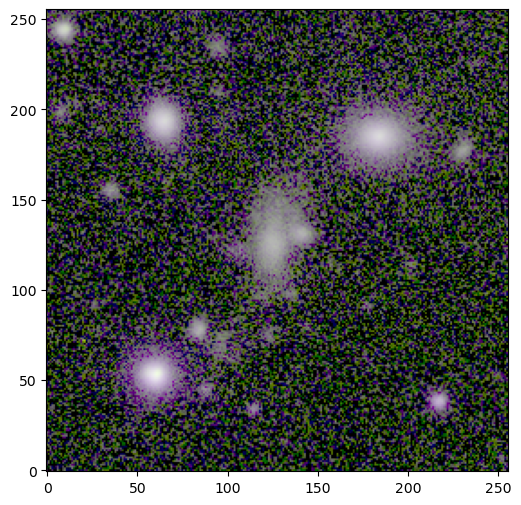

Object is at (241.5934, 29.2553) at a redshift of 0.0552
Zoobot pred: 0.283


In [223]:
idx = 3083

z = test["Z"][idx]
ra, dec = test["ra"][idx], test["dec"][idx]
zoobot_pred = test["zoobot_pred"][idx]

cutout = test["images"][idx]
cutout = np.moveaxis(cutout, 0, -1)
cutout = np.clip(cutout, 0, 1)

plt.figure(figsize=(6, 6), frameon=False, clear=True)
plt.imshow(cutout, origin="lower")
plt.show()

print(f"Object is at ({ra:.4f}, {dec:.4f}) at a redshift of {z:.4f}")
print(f"Zoobot pred: {zoobot_pred:.3f}")

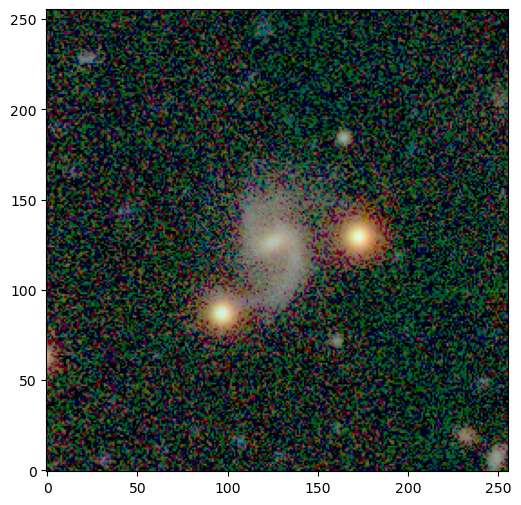

Object is at (261.4406, 33.0277) at a redshift of 0.1133
Zoobot pred: 0.004


In [387]:
idx = 4091

z = test_orig["Z"][idx]
ra, dec = test_orig["ra"][idx], test_orig["dec"][idx]
zoobot_pred = test_orig["zoobot_pred"][idx]

cutout = test_orig["images"][idx]

cutout_prep = preprocess_cutout(cutout, replace_anomaly=True, mode='na')
cutout_rgb = generate_rgb(cutout_prep, scaling_type='asinh_frac')

cutout_rgb = np.moveaxis(cutout_rgb, 0, -1)
cutout_rgb = np.clip(cutout_rgb, 0, 1)

plt.figure(figsize=(6, 6), frameon=False, clear=True)
plt.imshow(cutout_rgb, origin="lower")
plt.show()

print(f"Object is at ({ra:.4f}, {dec:.4f}) at a redshift of {z:.4f}")
print(f"Zoobot pred: {zoobot_pred:.3f}")

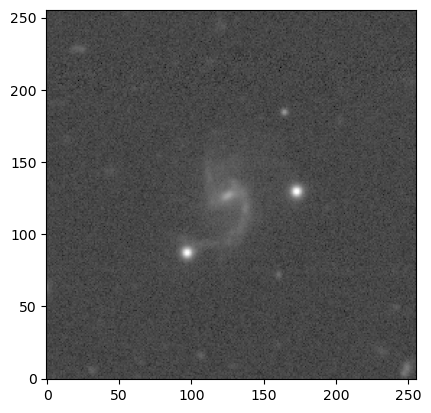

In [401]:
plt.figure(frameon=False)
plt.imshow(cutout_prep[:,:,2], norm=simple_norm(cutout_prep[:,:,2], 'log', percent=99.99), cmap='gray', origin='lower')
plt.show()

In [377]:
cutout_prep_orig = np.moveaxis(cutout_prep, -1, 0)

In [299]:
cutout_prep_orig[2]

array([[-172907.44, -173025.9 , -173144.42, ..., -204155.28, -204283.88,
        -204412.5 ],
       [-172868.72, -172987.17, -173105.64, ..., -204109.5 , -204238.06,
        -204366.66],
       [-172830.  , -172948.42, -173066.88, ..., -204063.73, -204192.25,
        -204320.83],
       ...,
       [-163248.58, -163360.38, -163472.2 , ..., -192734.78, -192856.11,
        -192977.48],
       [-163210.94, -163322.72, -163434.53, ..., -192690.28, -192811.6 ,
        -192932.94],
       [-163173.31, -163285.06, -163396.84, ..., -192645.8 , -192767.08,
        -192888.39]], dtype=float32)